# Initialization


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import ensemble
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
import warnings
from sklearn.exceptions import DataConversionWarning
import itertools

Hiding data conversion warnings generated by standard scaler.
Standard scaler expects float as input and converts input to float throwing a warning message.

In [2]:
warnings.filterwarnings(action='ignore', category=DataConversionWarning)


Reading part (1/n) of the data

In [3]:
def skiprow(i, n):
    if i % n == 0:
       return False
    return True


Change n to load more, or less of the data.

In [4]:
n=10
train_url='https://github.com/shobhitshah/MNIST-digit-recognizer/blob/develop/data/mnist-in-csv/mnist_train.csv.zip?raw=true'
test_url='https://github.com/shobhitshah/MNIST-digit-recognizer/blob/develop/data/mnist-in-csv/mnist_test.csv.zip?raw=true'
train = pd.read_csv(train_url, compression='zip', skiprows = lambda x: skiprow(x, n))
test = pd.read_csv(test_url, compression='zip' , skiprows = lambda x: skiprow(x, 1))

train.shape

(6000, 785)

In [5]:
train.sample(5)

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
2265,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2964,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
845,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5860,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2833,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Feature selection

In [6]:
y_train=train.label.values
X_train=train.drop('label', axis=1).values
X_test = test.drop('label', axis=1).values
y_test = test.label.values

# Define models

Multi label models.

In [7]:
models = []
models.append(('KNN', KNeighborsClassifier(5)))
models.append(('SVM', SVC(gamma='scale', C=1, decision_function_shape='ovo')))
models.append(('MLP', MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000, alpha=1e-4,
                    solver='sgd', verbose=2, tol=1e-4, random_state=1,
                    learning_rate_init=.1)))
models.append(('XGB', XGBClassifier(objective='multi:softmax', num_class=10, n_jobs=4, verbosity=2)))
models.append(('LR', LogisticRegression(solver="lbfgs", multi_class="multinomial", max_iter=1000, n_jobs=4))) # ovr - one versus reset
models.append(('RF', RandomForestClassifier(max_depth=5, n_estimators=10)))


# Model fitting and prediction

In [8]:
def model_score(model, X, y):
    score = model.score(X, y)
    return score

In [9]:
def model_fit(model, X_train, y_train):
    cv_scores = []
    kfold = StratifiedKFold(n_splits=5, shuffle=True)
    for train, val in kfold.split(X_train, y_train):
        model.fit(X_train[train], y_train[train])
        cv_score = model_score(model, X_train[val], y_train[val])
        print("Validation score for classifier... %.4f" % cv_score)
        cv_scores.append(cv_score)
    return cv_scores

## Comparaing model performance on scaled and unscaled features
https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html

In [10]:
def cv_fit_and_predict(models, X_train, y_train, X_test, y_test):
    results = []
    val_results = []
    for name, model in models:
        print("Processing model: ", name)
        clf = make_pipeline(StandardScaler(), model)
 
        #print("Un-scaled model...")
        #cv_scores = model_fit(model, X_train, y_train)
        #val_results.append((name+"_U", cv_scores))
        print("Scaled model...")
        cv_scores = model_fit(clf, X_train, y_train)
        val_results.append((name, cv_scores))

        print("Generating test scores for classifier... ")
        #score = model_score(model, X_test, y_test)
        #print("Test score for un-scaled classifier... %.4f" % score)
        #results.append((name+"_U", score))
        score = model_score(clf, X_test, y_test)
        print("Test score for scaled classifier... %.4f" % score)
        results.append((name, score))
    print("Done")
    return results, val_results


In [11]:
results, val_results = cv_fit_and_predict(models, X_train, y_train, X_test, y_test)

Processing model:  KNN
Scaled model...
Validation score for classifier... 0.9319
Validation score for classifier... 0.9252
Validation score for classifier... 0.9158
Validation score for classifier... 0.9132
Validation score for classifier... 0.9381
Generating test scores for classifier... 
Test score for scaled classifier... 0.8714
Processing model:  SVM
Scaled model...
Validation score for classifier... 0.9485
Validation score for classifier... 0.9476
Validation score for classifier... 0.9475
Validation score for classifier... 0.9441
Validation score for classifier... 0.9439
Generating test scores for classifier... 
Test score for scaled classifier... 0.9077
Processing model:  MLP
Scaled model...
Iteration 1, loss = 0.57422801
Iteration 2, loss = 0.16165509
Iteration 3, loss = 0.07502112
Iteration 4, loss = 0.04209613
Iteration 5, loss = 0.02646454
Iteration 6, loss = 0.01587119
Iteration 7, loss = 0.01024267
Iteration 8, loss = 0.00768287
Iteration 9, loss = 0.00615377
Iteration 10, 

# Validation and results

In [12]:
np_results=np.array(results, object)
np_val=np.array(val_results, object)

In [13]:
def plot_model_validation(results):
    fig, ax = plt.subplots(figsize=(13, 8))
    ax.boxplot(results[:,1])
    ax.set_xticklabels(results[:,0])
    ax.set_title('Model validation score')
    plt.show()
    
    return 0

In [14]:
def plot_model_test(results):
    plt.figure(figsize=(13, 8))
    bars = plt.bar(results[:, 0], results[:, 1])
    #bars[0].set_facecolor('r')

    #for bar in itertools.islice(bars, None, None, 2):  # start and stop None, step 2
    #    bar.set_facecolor('g')

    plt.xticks(results[:,0])
    plt.title('Model test score')
    plt.show()
    
    return 0

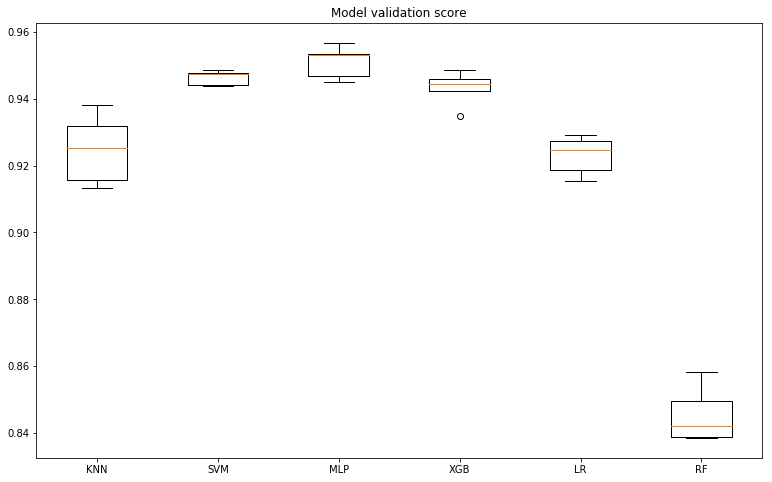

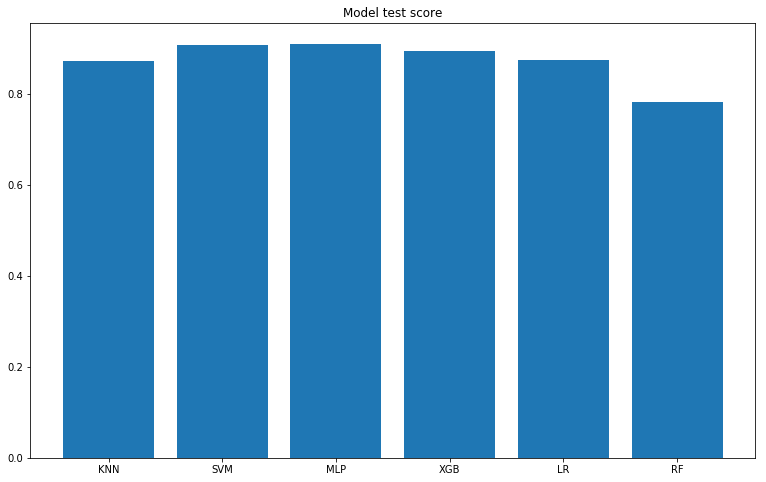

In [15]:
status = plot_model_validation(np_val)
status = plot_model_test(np_results)